# Real-fake Tweets metadata testing

## Requirements

### Imports

In [169]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings

warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report

### Check if a GPU is available

In [170]:
# Check if the GPU is working
if tf.test.gpu_device_name():
  print('GPU found')
else:
  print("No GPU found")

GPU found


### Set 'global' variables

In [171]:
batch_size = 64
epochs = 100
txt_size= 16

output_units = 3 # -1, 0 and 1

folder_path = '../../data/selected_data/'

### Pre-defined functions

In [172]:
def create_network(amount_features: int):
  return Sequential([
    # kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'
    Dense(512, activation='relu', input_shape=(amount_features,)),
    # Dense(512, activation='tanh'),
    Dropout(.5),

    Dense(256, activation='relu'),
    # Dense(256, activation='tanh'),
    Dropout(.5),

    Dense(128, activation='relu'),
    # Dense(128, activation='tanh'),
# , kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'
    Dropout(.5),

    Dense(64, activation='relu'),
    Dropout(.5),

    Dense(32, activation='relu'),
    Dropout(.5),
    # BatchNormalization(),
    Dense(3, activation='softmax')
  ])

def analyse_network(X, y, network: tuple[str, Sequential], epochs: int):
  return analyse_model(X, y, [network], epochs)

def analyse_model(X, y, models: list[tuple[str, Sequential]], epochs: int):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=111)

  print(f"Train shapes\n\tX:{X_train.shape}\n\ty:{y_train.shape}")
  print(f"Test shapes\n\tX:{X_test.shape}\n\ty:{y_test.shape}")

  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  encoder = LabelEncoder()

  y_train = encoder.fit_transform(y_train)
  y_test = encoder.transform(y_test)

  def print_seperator():
    print('\n' + ('#' * 150) + '\n')

  def execute(name: str, model: Sequential):
    start_time = time.time()
    print_seperator()

    print('\nCompiling model')
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    print('Fitting model')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test))

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'\nEvaluation:\nTest loss: {score[0]} / Test accuracy: {score[1]}')

    train_score = model.evaluate(X_train, y_train, verbose=0)

    elapsed_time = time.time() - start_time
    print(f'\tExecution time (seconds): {elapsed_time}')

    predictions = model.predict(X_test)

    return pd.concat([
      scores,
      pd.DataFrame({
        'Name': [name],
        'Test_Accuracy': [score[1]],
        'Test_Loss': [score[0]],
        "Train_Accuracy's": [history.history['accuracy']],
        'Train_Losses': [history.history['loss']],
        "Val_Accuracy's": [history.history['val_accuracy']],
        'Val_Losses': [history.history['val_loss']],
        'Train_Loss': [train_score[0]],
        'Train_Accuracy': [train_score[1]],
        'Y_test': [y_test],
        'Predictions': [predictions],
        'Execution_time': [elapsed_time]
      })
    ])

  scores = pd.DataFrame({
    'Name': [],
    'Test_Accuracy': [],
    'Test_Loss': [],
    "Train_Accuracy's": [],
    'Train_Losses': [],
    "Val_Accuracy's": [],
    'Val_Losses': [],
    'Train_Loss': [],
    'Train_Accuracy': [],
    'Y_test': [],
    'Predictions': [],
    'Execution_time': []
    })

  is_list = isinstance(models, list)

  if is_list:
    for name, model in models:
      scores = execute(name, model)
  else:
    name, model = models
    scores = execute(name, model)

  return scores

def plot_improved_model_comparison(name, models, show_overfitting = True):
  def set_basics(ax, title, x_label, y_label):
    ax.set_title(title, size=txt_size)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
  
  def set_plot_basics(ax, title, loss=False):
    ax.grid()
    ax.legend()
    set_basics(ax, title, 'Epochs', 'Loss' if loss else 'Accuracy')
  
  def set_bar_basics(ax, title, x, y, x_label, y_label, round_num=3, abbr = ''):
    set_basics(ax, title, x_label, y_label)
    bar = concat.plot.bar(y=y, x=x, ax=ax)

    for container in bar.containers:
      ax.bar_label(container, size=txt_size, fmt=f'%.{round_num}f{abbr}')

  rows = 3
  cols = 3
  figsize = (25, 22)

  if show_overfitting:
    cols = 2
    figsize = (25, 25)
  
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

  fig.suptitle(f'{name} model comparison', size=txt_size*1.5)

  concat = pd.concat(models)

  concat = concat.sort_values(by=['Test_Accuracy'], ascending=[False])

  axes = axes.flatten()

  if show_overfitting:
    [acc_ax, loss_ax, acc_bar_ax, loss_bar_ax, time_ax, _] = axes
  else:
    [train_acc_ax, val_acc_ax, train_loss_ax, val_loss_ax, acc_bar_ax, loss_bar_ax, time_ax, _, __] = axes

  for _, row in concat.iterrows():
    name = row['Name']
    if show_overfitting:
      acc_ax.plot(row["Train_Accuracy's"], label=name + '-Train', alpha=0.7)
      acc_ax.plot(row["Val_Accuracy's"], label=name + '-Validate', alpha=0.7)

      loss_ax.plot(row["Train_Losses"], label=name + '-Train', alpha=0.7)
      loss_ax.plot(row["Val_Losses"], label=name + '-Validate', alpha=0.7)
    else:
      train_acc_ax.plot(row["Train_Accuracy's"], label=name)
      val_acc_ax.plot(row["Val_Accuracy's"], label=name)

      val_loss_ax.plot(row["Val_Losses"], label=name)
      train_loss_ax.plot(row["Train_Losses"], label=name)
    
    # print the classification report
    y_test = row['Y_test']
    predictions = row['Predictions']

    flattend_pred = []
    # the predictions is an array of n rows with a depth of 3 so shape: (n, 3)
    # the classification report function only accepts 1D arrays so we need to 'flatten' the predictions
    for preds in predictions:
      highest = max(preds)
      index = list(preds).index(highest)

      # 0 = fake; 1 = neutral; 2 = real
      flattend_pred.append(index)
    print(f'{name} classification report:')
    print(classification_report(y_test, flattend_pred))

  set_bar_basics(
    ax = acc_bar_ax,
    title='Evaluation accuracy comparison\n(Higher is better)',
    x = 'Name',
    y = ['Test_Accuracy', 'Train_Accuracy'],
    x_label='Name',
    y_label='Accuracy'
  )

  set_bar_basics(
    ax = loss_bar_ax,
    title='Evaluation loss comparison\n(Lower is better)',
    x = 'Name',
    y = ['Test_Loss', 'Train_Loss'],
    x_label='Name',
    y_label='Loss'
  )
  
  set_bar_basics(
    ax = time_ax,
    title='Execution time\n(In seconds & lower is better)',
    x = 'Name',
    y = ['Execution_time'],
    x_label='Name',
    y_label='Execution time',
    round_num=2,
    abbr='s'
  )

  if show_overfitting:
    acc_ax.set_xlim([0,epochs])
    loss_ax.set_xlim([0,epochs])

    set_plot_basics(acc_ax, 'Accuracy')
    set_plot_basics(loss_ax, 'Loss', True)
    pass
  else:
    train_acc_ax.set_xlim([0,epochs])
    val_acc_ax.set_xlim([0,epochs])
    train_loss_ax.set_xlim([0,epochs])
    val_loss_ax.set_xlim([0,epochs])

    set_plot_basics(train_acc_ax, 'Training accuracy')
    set_plot_basics(val_acc_ax, 'Validating accuracy')

    set_plot_basics(train_loss_ax, 'Training loss comparison', True)
    set_plot_basics(val_loss_ax, 'Validating loss comparison', True)
  
  plt.show()
  pass

## Test all dataframes

### Test all columns

In [173]:
all_df = pd.read_csv(folder_path + 'all_data_selected.csv')

all_df.head(3)

,Unnamed: 0,full_text,retweet_count,user_description,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_media_count,hashtags_count,...,part_of_thread,tweet_sentiment,user_creation_tweet_diff,tweeted_in_daypart_day,tweeted_in_daypart_evening,tweeted_in_daypart_morning,tweeted_in_daypart_night,user_created_in_daypart_day,user_created_in_daypart_evening,real_fake_grade
0,0,Our daily update is published. States reported...,171,We try to provide the most comprehensive state...,468030,13,85,2594,1364,0,...,0,0,16384932,0,1,0,0,0,0,1.0
1,1,President Trump Asked What He Would Do If He W...,0,"Spoof news, political satire, parody and more!...",803,97,1,57502,3,2,...,0,0,293776787,1,0,0,0,0,0,-1.0
2,2,States reported 630 deaths. We are still seein...,71,We try to provide the most comprehensive state...,468030,13,85,2594,1364,0,...,1,0,9039963,0,1,0,0,0,0,1.0


In [174]:
X = all_df.drop(axis=1, columns=['real_fake_grade', 'full_text', 'user_description', 'username', 'Unnamed: 0']).values
y = all_df['real_fake_grade'].values

In [175]:
nn = create_network(X.shape[1])

In [176]:
analysed_all_columns = analyse_network(X, y, ('All-nn', nn), epochs)

Train shapes
	X:(6324, 40)
	y:(6324,)
Test shapes
	X:(1581, 40)
	y:(1581,)

######################################################################################################################################################


Compiling model
Fitting model
Epoch 1/100
99/99 [==============================] - 1s 8ms/step - loss: 0.9350 - accuracy: 0.5515 - val_loss: 0.8449 - val_accuracy: 0.5920
Epoch 2/100
99/99 [==============================] - 1s 6ms/step - loss: 0.8189 - accuracy: 0.5862 - val_loss: 0.7945 - val_accuracy: 0.6015
Epoch 3/100
99/99 [==============================] - 1s 7ms/step - loss: 0.7864 - accuracy: 0.6039 - val_loss: 0.7856 - val_accuracy: 0.5712
Epoch 4/100
99/99 [==============================] - 1s 6ms/step - loss: 0.7666 - accuracy: 0.6029 - val_loss: 0.7742 - val_accuracy: 0.5806
Epoch 5/100
99/99 [==============================] - 1s 7ms/step - loss: 0.7422 - accuracy: 0.6123 - val_loss: 0.7540 - val_accuracy: 0.5825
Epoch 6/100
99/99 [=================

All-nn classification report:
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       464
           1       0.40      0.15      0.22       187
           2       0.79      0.78      0.79       930

    accuracy                           0.69      1581
   macro avg       0.58      0.55      0.54      1581
weighted avg       0.68      0.69      0.67      1581



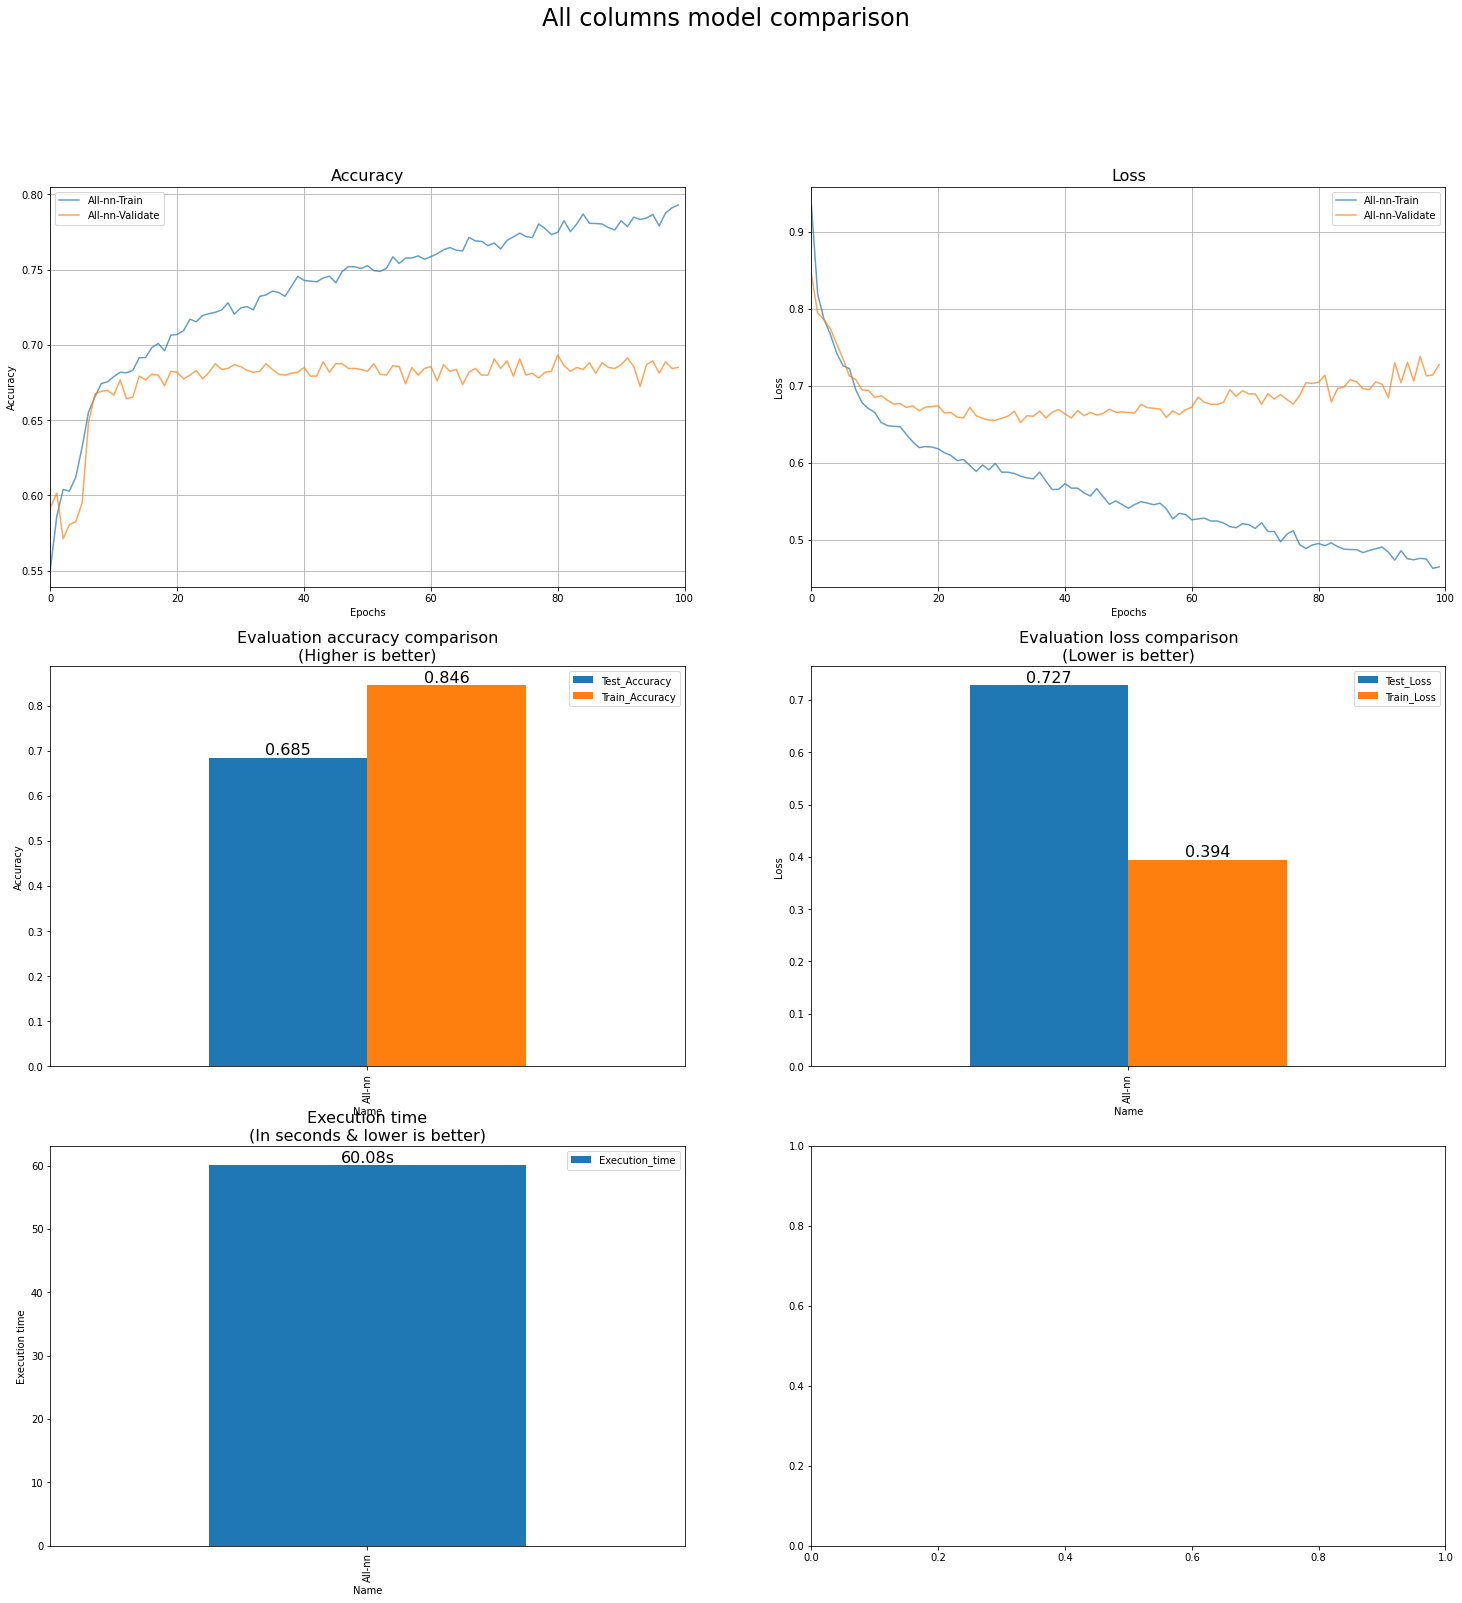

In [177]:
plot_improved_model_comparison('All columns', [analysed_all_columns], True)

### Test Tweet columns

In [178]:
tweet_df = pd.read_csv(folder_path+ 'tweet_data_selected.csv')

tweet_df.head(3)

,Unnamed: 0.1,Unnamed: 0,retweet_count,hashtags_count,text_length,sent_via_twitter,twitter_android_user,tweeted_in_weekend,possibly_sensitive_media,tweet_contains_url,tweet_contains_media,tweet_is_reply,part_of_thread,tweeted_in_daypart_day,tweeted_in_daypart_evening,tweeted_in_daypart_morning,tweeted_in_daypart_night,user_description_sentiment,tweet_sentiment,real_fake_grade
0,0,0,171,0,163,1,0,1,0,0,1,0,0,0,1,0,0,4,0,1.0
1,1,1,0,2,125,0,0,0,0,1,0,0,0,1,0,0,0,4,0,-1.0
2,2,2,71,0,245,1,0,1,0,0,1,1,1,0,1,0,0,4,0,1.0


In [179]:
tweet_X = tweet_df.drop(axis=1, columns=['real_fake_grade']).values
tweet_y = tweet_df['real_fake_grade'].values

In [180]:
tweet_nn = create_network(tweet_X.shape[1])

In [181]:
analysed_tweet_columns = analyse_network(tweet_X, tweet_y, ('Tweet-nn', tweet_nn), epochs)

Train shapes
	X:(6324, 19)
	y:(6324,)
Test shapes
	X:(1581, 19)
	y:(1581,)

######################################################################################################################################################


Compiling model
Fitting model
Epoch 1/100
99/99 [==============================] - 1s 7ms/step - loss: 0.9672 - accuracy: 0.5226 - val_loss: 0.8487 - val_accuracy: 0.5882
Epoch 2/100
99/99 [==============================] - 1s 6ms/step - loss: 0.8617 - accuracy: 0.5816 - val_loss: 0.8222 - val_accuracy: 0.5882
Epoch 3/100
99/99 [==============================] - 1s 6ms/step - loss: 0.8225 - accuracy: 0.5903 - val_loss: 0.7953 - val_accuracy: 0.6388
Epoch 4/100
99/99 [==============================] - 1s 6ms/step - loss: 0.8004 - accuracy: 0.6101 - val_loss: 0.7602 - val_accuracy: 0.6471
Epoch 5/100
99/99 [==============================] - 1s 6ms/step - loss: 0.7850 - accuracy: 0.6278 - val_loss: 0.7582 - val_accuracy: 0.6622
Epoch 6/100
99/99 [=================

Tweet-nn classification report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       464
           1       0.00      0.00      0.00       187
           2       0.68      0.93      0.79       930

    accuracy                           0.70      1581
   macro avg       0.48      0.48      0.47      1581
weighted avg       0.62      0.70      0.64      1581



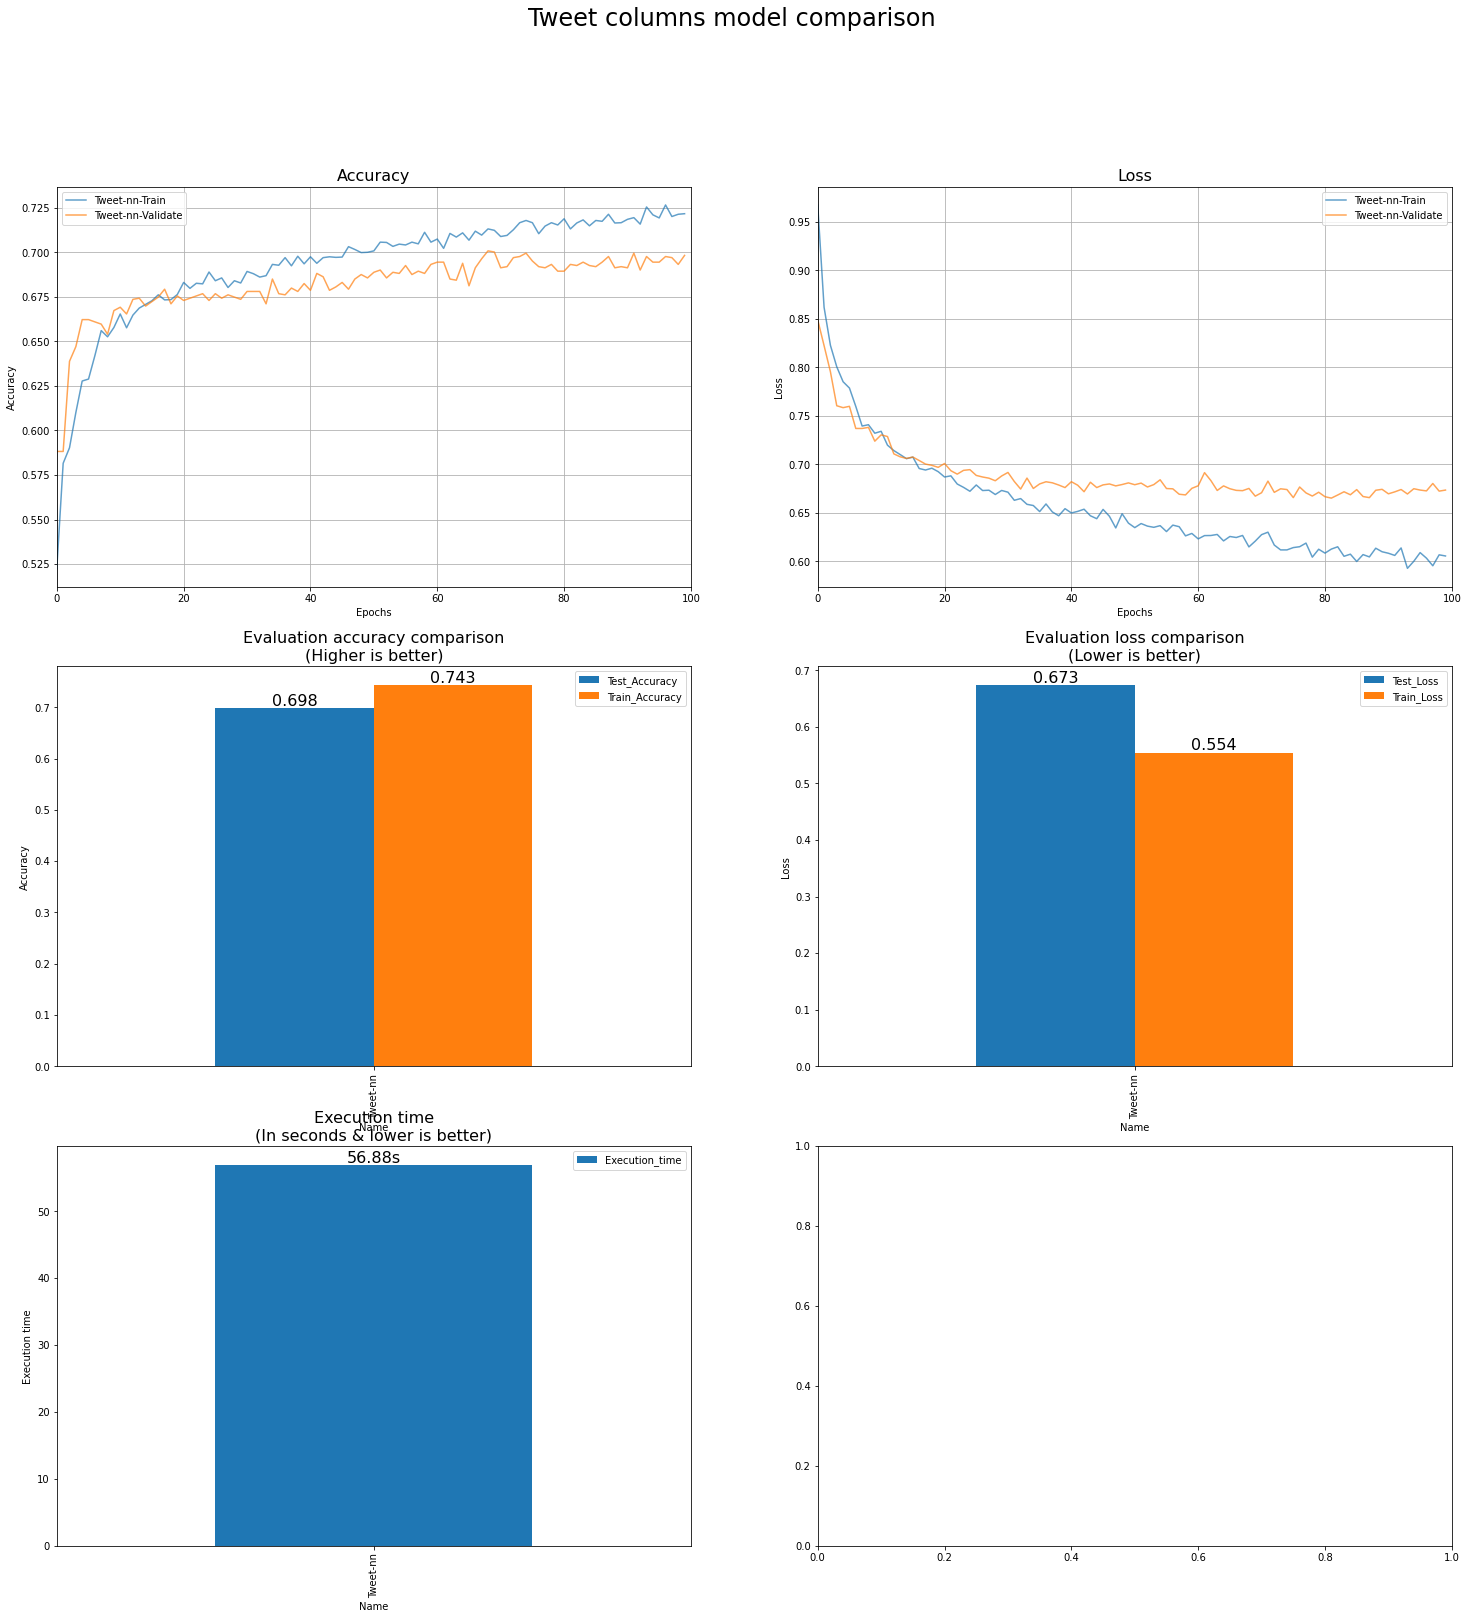

In [182]:
plot_improved_model_comparison('Tweet columns', [analysed_tweet_columns], True)

### Test user columns

In [183]:
user_df = pd.read_csv(folder_path+ 'user_data_selected.csv')

user_df.head(3)

,Unnamed: 0.1,Unnamed: 0,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_media_count,has_user_url,user_created_in_weekend,user_is_verified,...,user_service_level_analytics,user_service_level_dso,user_service_level_media_studio,user_service_level_reseller,user_service_level_smb,user_decscription_has_urls,user_creation_tweet_diff,user_created_in_daypart_day,user_created_in_daypart_evening,real_fake_grade
0,0,0,468030,13,85,2594,1364,1,1,1,...,0,0,0,0,0,0,16384932,0,0,1.0
1,1,1,803,97,1,57502,3,1,0,0,...,1,0,0,0,0,0,293776787,0,0,-1.0
2,2,2,468030,13,85,2594,1364,1,1,1,...,0,0,0,0,0,0,9039963,0,0,1.0


In [184]:
user_X = tweet_df.drop(axis=1, columns=['real_fake_grade']).values
user_y = tweet_df['real_fake_grade'].values

In [185]:
user_nn = create_network(user_X.shape[1])

In [186]:
analysed_user_columns = analyse_network(tweet_X, tweet_y, ('User-nn', user_nn), epochs)

Train shapes
	X:(6324, 19)
	y:(6324,)
Test shapes
	X:(1581, 19)
	y:(1581,)

######################################################################################################################################################


Compiling model
Fitting model
Epoch 1/100
99/99 [==============================] - 1s 7ms/step - loss: 0.9736 - accuracy: 0.5259 - val_loss: 0.8599 - val_accuracy: 0.5882
Epoch 2/100
99/99 [==============================] - 1s 5ms/step - loss: 0.8655 - accuracy: 0.5811 - val_loss: 0.8309 - val_accuracy: 0.6053
Epoch 3/100
99/99 [==============================] - 1s 6ms/step - loss: 0.8329 - accuracy: 0.5950 - val_loss: 0.8013 - val_accuracy: 0.6369
Epoch 4/100
99/99 [==============================] - 1s 6ms/step - loss: 0.8077 - accuracy: 0.6113 - val_loss: 0.7713 - val_accuracy: 0.6471
Epoch 5/100
99/99 [==============================] - 1s 6ms/step - loss: 0.7890 - accuracy: 0.6251 - val_loss: 0.7800 - val_accuracy: 0.6534
Epoch 6/100
99/99 [=================

User-nn classification report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.61       464
           1       0.00      0.00      0.00       187
           2       0.69      0.92      0.79       930

    accuracy                           0.70      1581
   macro avg       0.47      0.48      0.47      1581
weighted avg       0.62      0.70      0.64      1581



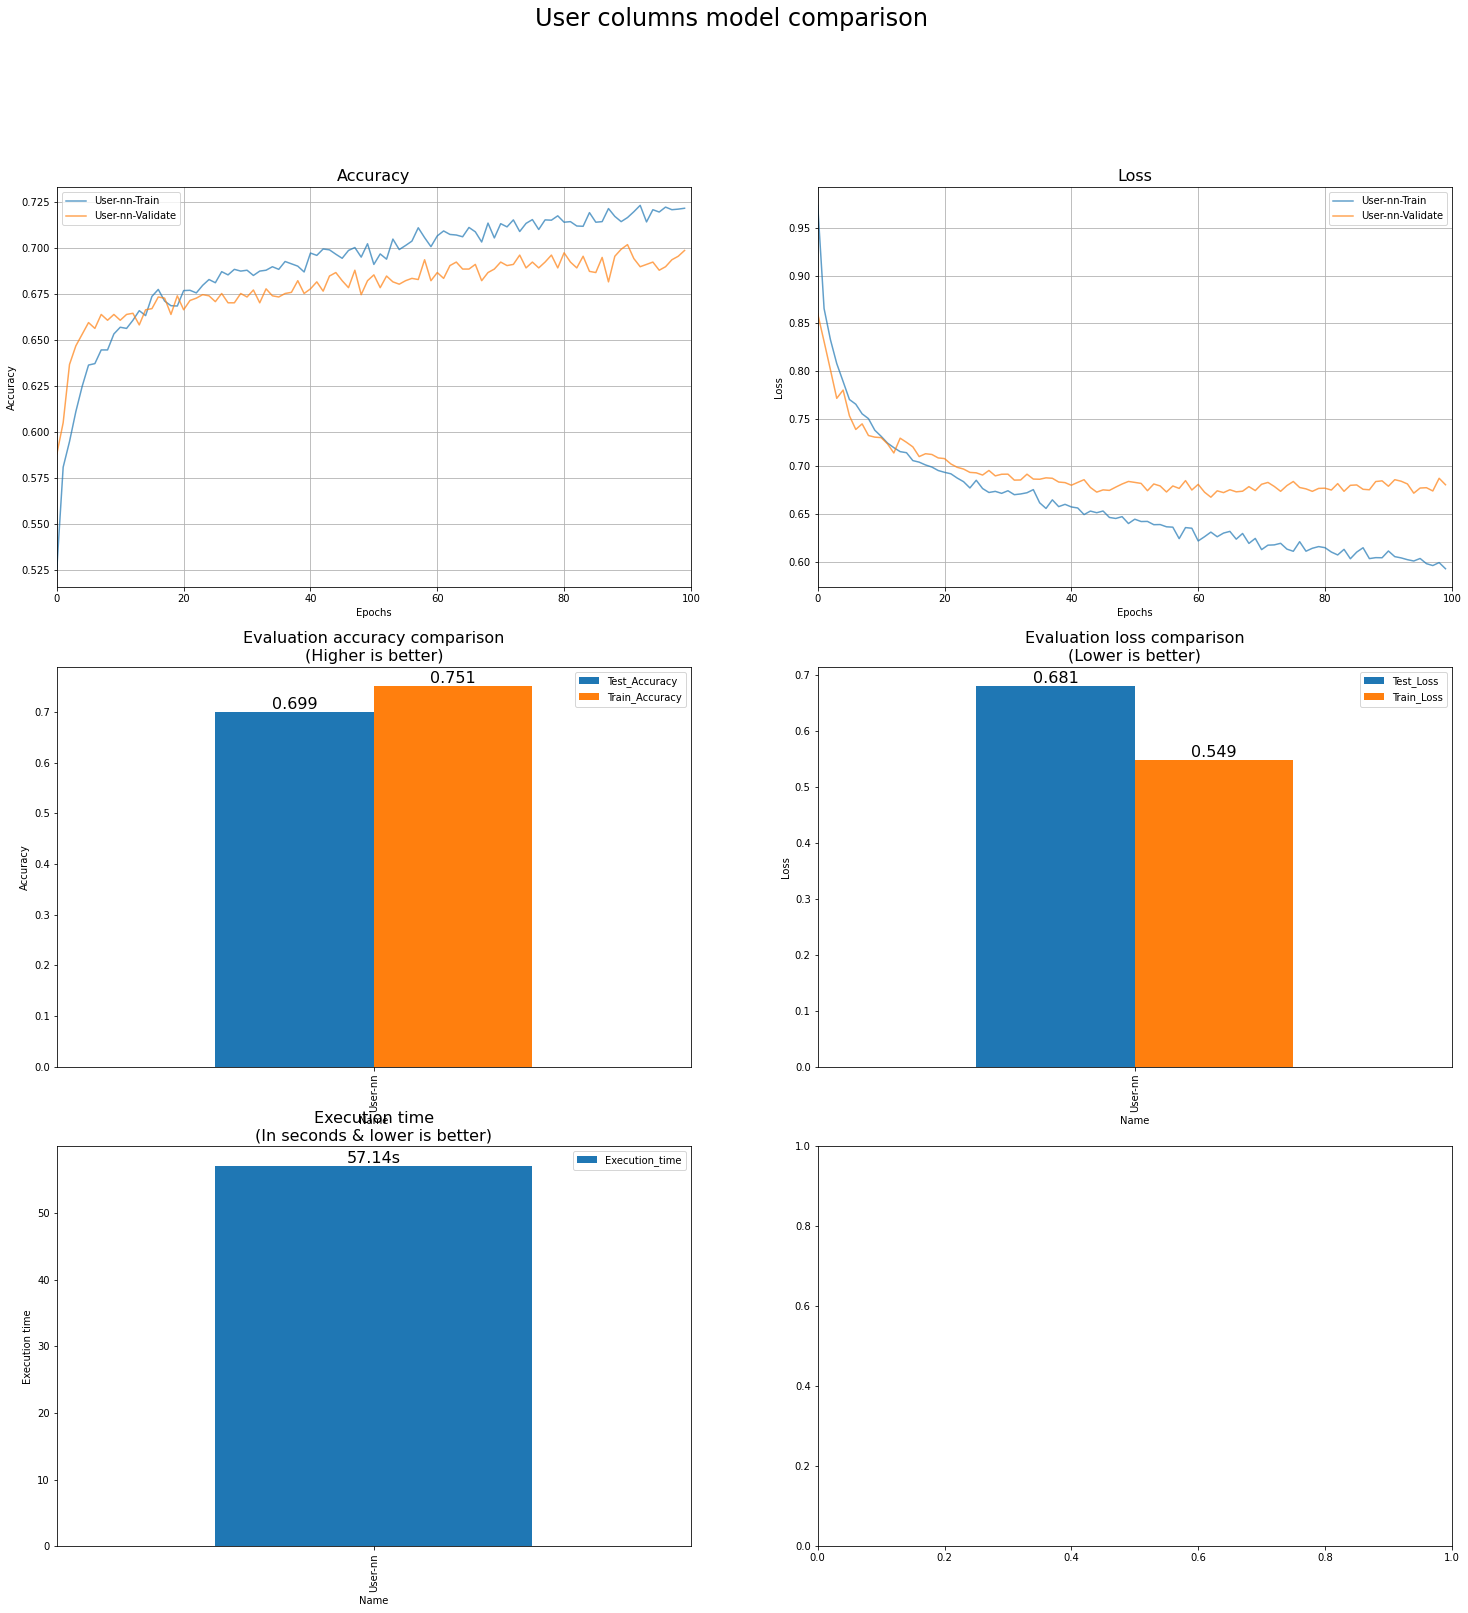

In [187]:
plot_improved_model_comparison('User columns', [analysed_user_columns], True)

## Analyse all the results combined

User-nn classification report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.61       464
           1       0.00      0.00      0.00       187
           2       0.69      0.92      0.79       930

    accuracy                           0.70      1581
   macro avg       0.47      0.48      0.47      1581
weighted avg       0.62      0.70      0.64      1581

Tweet-nn classification report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       464
           1       0.00      0.00      0.00       187
           2       0.68      0.93      0.79       930

    accuracy                           0.70      1581
   macro avg       0.48      0.48      0.47      1581
weighted avg       0.62      0.70      0.64      1581

All-nn classification report:
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       464
           1       0.40      0.15   

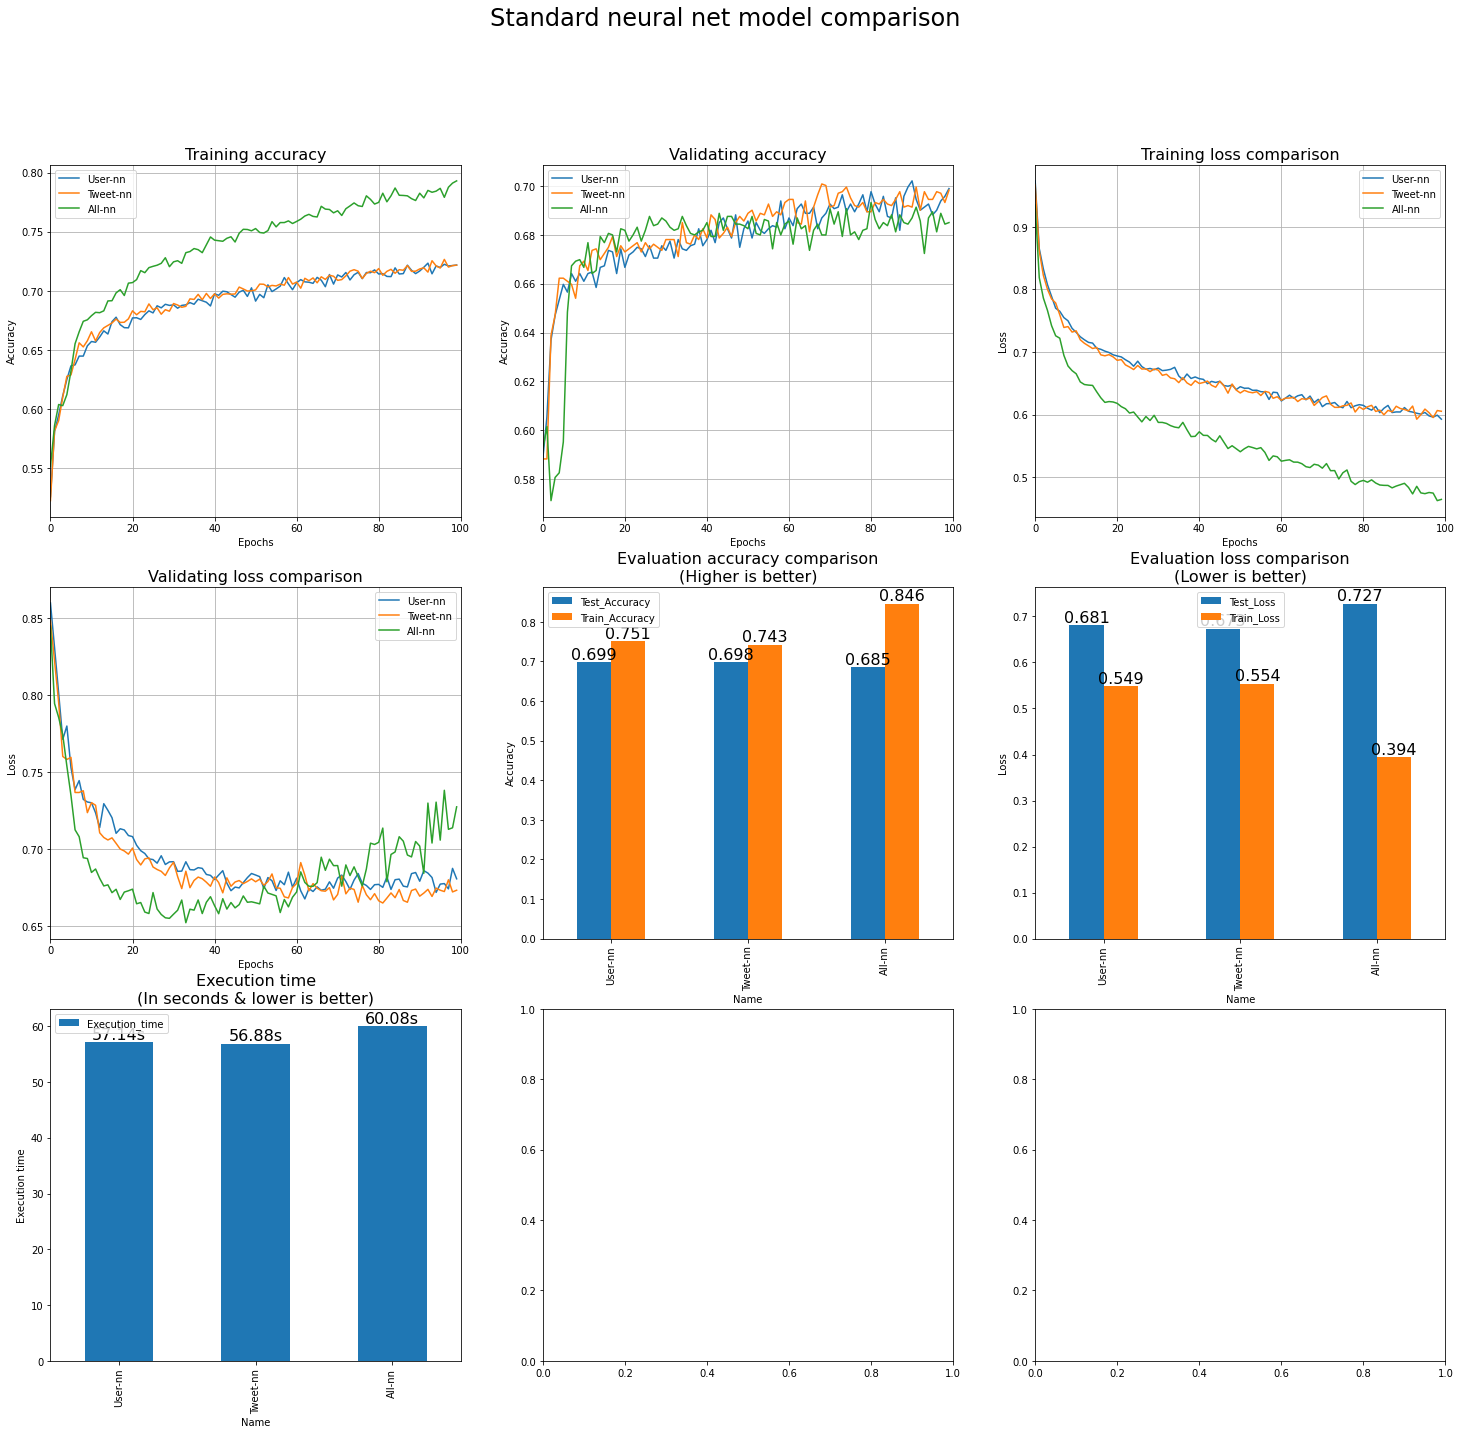

In [188]:
scores = [
  analysed_user_columns,
  analysed_tweet_columns,
  analysed_all_columns
]

plot_improved_model_comparison('Standard neural net', scores, False)

In [189]:
nn.save('nn_model.h5')